# Analysis of post-workshop survey data which we collect 3-6 months after a workshop

In [2]:
from dataclasses import dataclass

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
# larger font in seaborn plots
sns.set(font_scale=2)

In [4]:
# reduce annoying differences in column titles
def normalize_column_title(s):
    s = s.replace("Post-workshop survey: ", "")
    s = s.replace("Background information: ", "")
    s = s.replace("Impact of the workshop: ", "")
    return s

## Job title/ position/ occupation

In [16]:
def extract_typeform_positions(file_name):
    _df = pd.read_csv(file_name)
    # in these datasets the "other" is a separate column
    # in this case fill the "non-other" column with the value from "other"
    _df["What is your current position?"].fillna(_df["Other"], inplace=True)
    return _df["What is your current position?"].to_frame()

In [17]:
def extract_indico_positions(file_name):
    _df = pd.read_csv(file_name)
    _df = _df.rename(normalize_column_title, axis='columns')
    return _df["What is your current position?"].to_frame()

In [18]:
positions = pd.concat([
    extract_typeform_positions("data/typeform/2017.csv"),
    extract_typeform_positions("data/typeform/2018.csv"),
    extract_indico_positions("data/indico/2018.csv"),
    extract_indico_positions("data/indico/2019-a.csv"),
    extract_indico_positions("data/indico/2019-b.csv"),
    extract_indico_positions("data/indico/2019-c-2020.csv"),
])["What is your current position?"]

unique_positions = positions.unique()
counts = positions.value_counts()

values summing up to 284


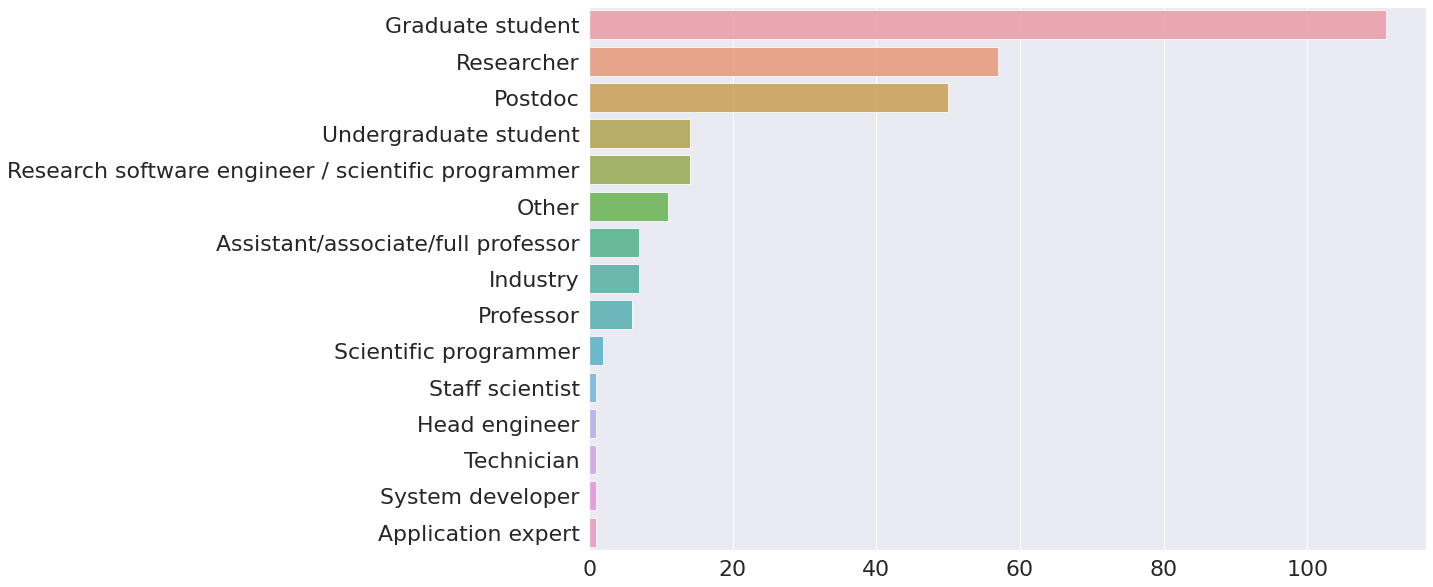

In [19]:
f, ax = plt.subplots(figsize=(15, 10))

sns.barplot(y=counts.index.str.capitalize(), x=counts.values, alpha=0.8)

f.savefig("figures/position.png", bbox_inches = 'tight')

print(f"values summing up to {sum(counts.values)}")

## Impact on code quality and collaboration

I didn't use mean() because this gave a different result since it would
ignore those rows where there is no answer and only consider rows with 0 or 1.

In [5]:
@dataclass
class QualityCount:
    reusable: int = 0
    reproducible: int = 0
    modular: int = 0
    documented: int = 0
    easier_to_collaborate: int = 0
    introduced_colleagues: int = 0
    def add(self, other):
        self.reusable += other.reusable
        self.reproducible += other.reproducible
        self.modular += other.modular
        self.documented += other.documented
        self.easier_to_collaborate += other.easier_to_collaborate
        self.introduced_colleagues += other.introduced_colleagues

In [6]:
def extract_indico_code_quality(file_name):
    _df = pd.read_csv(file_name)
    _df = _df.rename(normalize_column_title, axis='columns')

    count = QualityCount()
    
    for line in _df["Would you judge your code to be better reusable/reproducible/modular/documented as a result of attending the workshop?"]:
        if "More reusable" in line:
            count.reusable += 1
        if "More reproducible" in line:
            count.reproducible += 1
        if "More modular" in line:
            count.modular += 1
        if "Better documented" in line:
            count.documented += 1

    for line in _df["Has it become easier for you to collaborate on software development with your colleagues and collaborators?"]:
        if "Yes" in line:
            count.easier_to_collaborate += 1        

    for line in _df["Have you introduced one or more of your colleagues to new tools or practices as a result of the workshop?"]:
        if "Yes" in line:
            count.introduced_colleagues += 1 
            
    return count

In [7]:
def extract_typeform_code_quality(file_name):
    _df = pd.read_csv(file_name)

    count = QualityCount()
    
    count.reusable += int(_df["Reusable"].sum())
    count.reproducible += int(_df["Reproducible"].sum())
    count.modular += int(_df["Modular"].sum())
    count.documented += int(_df["Documented"].sum())

    c = [col for col in _df.columns if 'easier for you to collaborate' in col][0]
    count.easier_to_collaborate += int(_df[c].sum())
    
    c = [col for col in _df.columns if 'introduced one or more' in col][0]
    count.introduced_colleagues += int(_df[c].sum())

    return count

In [8]:
num_answers = 0

for file_name in [
    "data/typeform/2017.csv",
    "data/typeform/2018.csv",
    "data/indico/2018.csv",
    "data/indico/2019-a.csv",
    "data/indico/2019-b.csv",
    "data/indico/2019-c-2020.csv",
]:
    _df = pd.read_csv(file_name)
    num_answers += _df.shape[0]

print(f"number of survey respondents: {num_answers}")

number of survey respondents: 285


In [9]:
count = QualityCount()

count.add(extract_typeform_code_quality("data/typeform/2017.csv"))
count.add(extract_typeform_code_quality("data/typeform/2018.csv"))  

count.add(extract_indico_code_quality("data/indico/2018.csv"))
count.add(extract_indico_code_quality("data/indico/2019-a.csv"))
count.add(extract_indico_code_quality("data/indico/2019-b.csv"))
count.add(extract_indico_code_quality("data/indico/2019-c-2020.csv"))

In [10]:
yesno = pd.DataFrame(columns = ['Question', 'Fraction'])

yesno = yesno.append({'Question': 'More reusable?',
                      'Fraction': count.reusable/num_answers},
                     ignore_index = True)
yesno = yesno.append({'Question': 'More reproducible?',
                      'Fraction': count.reproducible/num_answers},
                     ignore_index = True)
yesno = yesno.append({'Question': 'More modular?',
                      'Fraction': count.modular/num_answers},
                     ignore_index = True)
yesno = yesno.append({'Question': 'Better documented?',
                      'Fraction': count.documented/num_answers},
                     ignore_index = True)
yesno = yesno.append({'Question': 'Easier to collaborate?',
                      'Fraction': count.easier_to_collaborate/num_answers},
                     ignore_index = True)
yesno = yesno.append({'Question': 'Introduced tools to colleagues?',
                      'Fraction': count.introduced_colleagues/num_answers},
                     ignore_index = True)

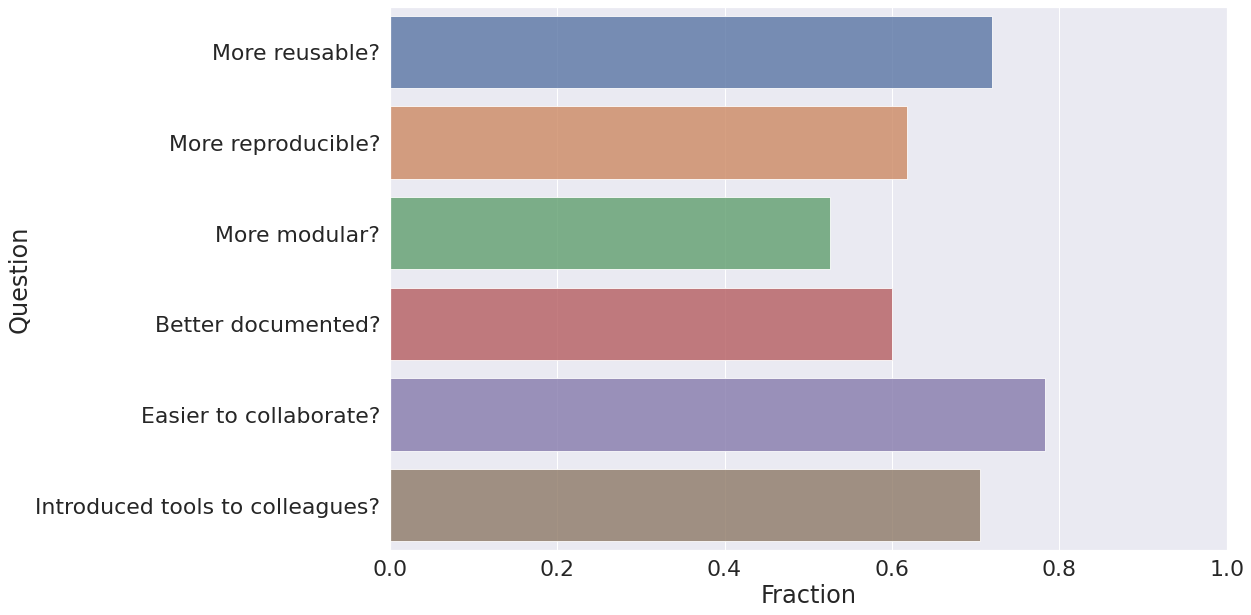

In [26]:
f, ax = plt.subplots(figsize=(15, 10))

g = sns.barplot(y=yesno.Question, x=yesno.Fraction, alpha=0.8)
g.set(xlim=(0.0, 1.0))

f.savefig("figures/yes-no-questions.png", bbox_inches = 'tight')

## Impact on usage of software development tools

In [11]:
@dataclass
class ToolCount:
    not_using: int = 0
    started: int = 0
    better: int = 0
    unchanged: int = 0
    def add(self, other):
        self.not_using += other.not_using
        self.started += other.started
        self.better += other.better
        self.unchanged += other.unchanged

In [12]:
def impact_tool_typeform(file_name, tool):
    _df = pd.read_csv(file_name)

    count = ToolCount()

    count.not_using += len(_df[_df[tool].str.contains("don't use")])
    count.started += len(_df[_df[tool].str.contains("started using")])
    count.better += len(_df[_df[tool].str.contains("better than before")])
    count.unchanged += len(_df[_df[tool].str.contains("same way as before")])

    return count

In [13]:
def impact_tool_indico(file_name, tool):
    _df = pd.read_csv(file_name)

    count = ToolCount()

    c = [col for col in _df.columns if 'not using' in col]
    if len(c) > 0:
        count.not_using += len(_df[_df[c[0]].str.contains(tool)])
    c = [col for col in _df.columns if 'not yet using' in col]
    if len(c) > 0:
        count.not_using += len(_df[_df[c[0]].str.contains(tool)])
    
    c = [col for col in _df.columns if 'started using as a result' in col]
    count.started += len(_df[_df[c[0]].str.contains(tool)])

    c = [col for col in _df.columns if 'are you using better' in col]
    count.better += len(_df[_df[c[0]].str.contains(tool)])

    c = [col for col in _df.columns if 'same way as' in col]
    count.unchanged += len(_df[_df[c[0]].str.contains(tool)])

    return count

In [14]:
def impact_tool(file_name, tool):
    if "indico" in file_name:
        return impact_tool_indico(file_name, tool)
    elif "typeform" in file_name:
        return impact_tool_typeform(file_name, tool)

In [15]:
typeform_files = [
    "data/typeform/2017.csv",
    "data/typeform/2018.csv",
]

indico_files = [
    "data/indico/2018.csv",
    "data/indico/2019-a.csv",
    "data/indico/2019-b.csv",
    "data/indico/2019-c-2020.csv",
]

all_files = typeform_files + indico_files

d = {}

d["Version control"] = ToolCount()
for file_name in all_files:
    d["Version control"].add(impact_tool(file_name, "Version control"))

d["Automated testing"] = ToolCount()
for file_name in typeform_files:
    d["Automated testing"].add(impact_tool(file_name, "Automated testing"))
    d["Automated testing"].add(impact_tool(file_name, "Travis CI"))
for file_name in indico_files:
    d["Automated testing"].add(impact_tool(file_name, "Automated testing"))

d["Coverage"] = ToolCount()
for file_name in all_files:
    d["Coverage"].add(impact_tool(file_name, "Code coverage analysis"))  
    
d["Jupyter"] = ToolCount()
for file_name in all_files:
    d["Jupyter"].add(impact_tool(file_name, "Jupyter Notebooks"))  

d["CMake"] = ToolCount()
for file_name in all_files:
    d["CMake"].add(impact_tool(file_name, "CMake"))  

# not part of typeform data
d["Workflows"] = ToolCount()
for file_name in indico_files:
    d["Workflows"].add(impact_tool(file_name, "Workflow"))  

d["IDEs"] = ToolCount()
for file_name in all_files:
    d["IDEs"].add(impact_tool(file_name, "Integrated development environments"))

d["Code review"] = ToolCount()
for file_name in all_files:
    d["Code review"].add(impact_tool(file_name, "Code review"))

d["Deploying documentation"] = ToolCount()
for file_name in indico_files:
    # NT: both "D" and "d" is used in different survey events: "d" is used in 2018.csv, and "D" elsewhere.
    d["Deploying documentation"].add(impact_tool(file_name, "Read the Docs"))
    d["Deploying documentation"].add(impact_tool(file_name, "Read the docs"))  
# Survey respondents misunderstood the question on "GitHub/GitLab/Bitbucket Pages" in the 2017 survey
# RB: can we explain here why we think this question was misunderstood?
d["Deploying documentation"].add(impact_tool("data/typeform/2017.csv", "Read the docs"))
d["Deploying documentation"].add(impact_tool("data/typeform/2018.csv", "Read the Docs or GitHub/GitLab/BitBucket Pages"))

In [16]:
table = pd.DataFrame(columns = ['Tool', 'Impact', 'Count'], dtype="float")
for k, v in d.items():
    table = table.append({'Tool': k, 'Impact': 'Not using', 'Count': v.not_using}, ignore_index = True)
    table = table.append({'Tool': k, 'Impact': 'Started using', 'Count': v.started}, ignore_index = True)
    table = table.append({'Tool': k, 'Impact': 'Using better', 'Count': v.better}, ignore_index = True)
    table = table.append({'Tool': k, 'Impact': 'Unchanged', 'Count': v.unchanged}, ignore_index = True)
    
result = table.pivot(index='Tool', columns='Impact', values='Count')    

# make sure tools are listed in the same order as added further up
result = result[::-1]

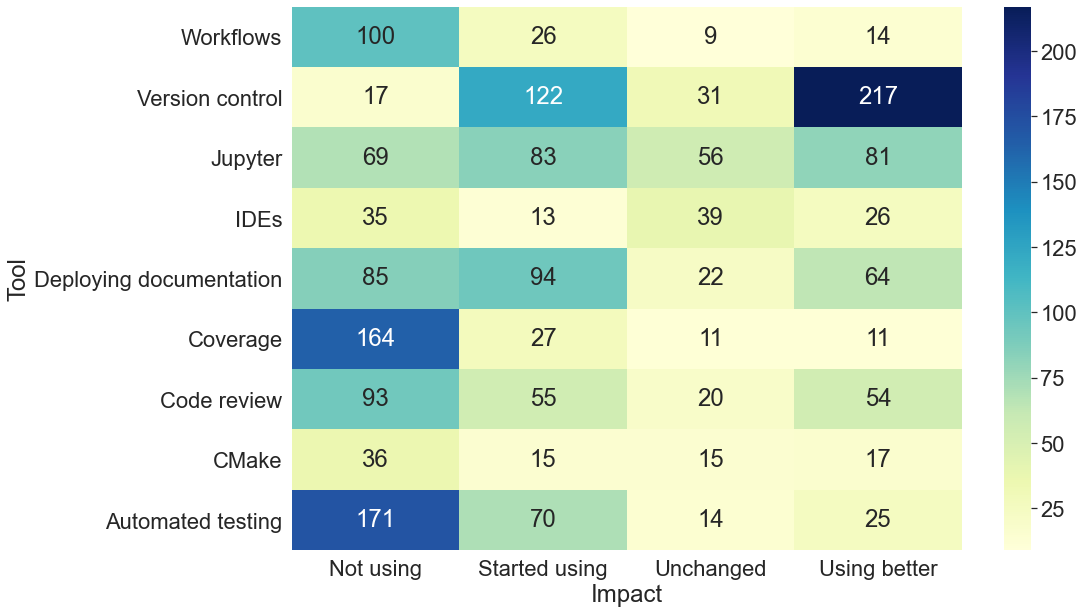

In [17]:
f, ax = plt.subplots(figsize=(15, 10))

g = sns.heatmap(result, fmt="g", cmap="YlGnBu", annot=True)
g.set_yticklabels(g.get_yticklabels(), rotation=0) 

f.savefig("figures/heatmap.png", bbox_inches = 'tight')